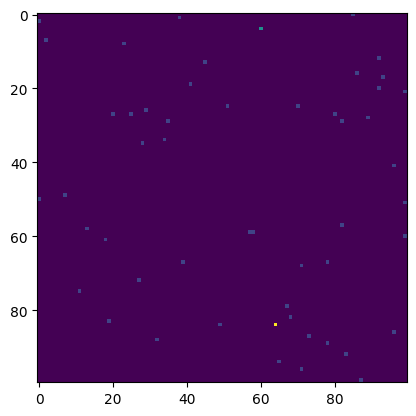

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

class GridEnvironment:
    def __init__(self, size=100, num_obstacles=50):
        self.size = size
        self.num_obstacles = num_obstacles
        self.start = (random.randint(0, size-1), random.randint(0, size-1))
        self.goal = (random.randint(0, size-1), random.randint(0, size-1))
        
        while self.goal == self.start:
            self.goal = (random.randint(0, size-1), random.randint(0, size-1))

        self.obstacles = set()
        while len(self.obstacles) < num_obstacles:
            obstacle = (random.randint(0, size-1), random.randint(0, size-1))
            if obstacle != self.start and obstacle != self.goal:
                self.obstacles.add(obstacle)

    def display_grid(self):
        grid = np.zeros((self.size, self.size))
        grid[self.start] = 0.5  # Start point in green
        grid[self.goal] = 1.0   # Goal point in yellow

        for (x, y) in self.obstacles:
            grid[x, y] = 0.2  # Obstacle color

        plt.imshow(grid, cmap='viridis')
        plt.show()

    def is_goal(self, state):
        return state == self.goal

    def move(self, state, action):
        next_state = (state[0] + action[0], state[1] + action[1])
        if (0 <= next_state[0] < self.size and 0 <= next_state[1] < self.size
            and next_state not in self.obstacles):
            return next_state
        return state  # If move is invalid or hits an obstacle, stay in the same state

class MDPAgent:
    def __init__(self, env, discount_factor=0.9, threshold=1e-4):
        self.env = env
        self.size = env.size
        self.discount_factor = discount_factor
        self.threshold = threshold
        self.value_table = np.zeros((self.size, self.size))
        self.policy = { (x, y): random.choice([(0,1), (1,0), (0,-1), (-1,0)])
                        for x in range(self.size) for y in range(self.size) }

    def policy_evaluation(self):
        while True:
            delta = 0
            for x in range(self.size):
                for y in range(self.size):
                    state = (x, y)
                    if self.env.is_goal(state) or state in self.env.obstacles:
                        continue
                    v = self.value_table[state]
                    action = self.policy[state]
                    next_state = self.env.move(state, action)
                    reward = -1 if next_state not in self.env.obstacles else -100
                    self.value_table[state] = reward + self.discount_factor * self.value_table[next_state]
                    delta = max(delta, abs(v - self.value_table[state]))
            if delta < self.threshold:
                break

    def policy_improvement(self):
        policy_stable = True
        for x in range(self.size):
            for y in range(self.size):
                state = (x, y)
                if self.env.is_goal(state) or state in self.env.obstacles:
                    continue
                old_action = self.policy[state]
                action_values = {}
                for action in [(0,1), (1,0), (0,-1), (-1,0)]:
                    next_state = self.env.move(state, action)
                    reward = -1 if next_state not in self.env.obstacles else -100
                    action_values[action] = reward + self.discount_factor * self.value_table[next_state]
                self.policy[state] = max(action_values, key=action_values.get)
                if old_action != self.policy[state]:
                    policy_stable = False
        return policy_stable

    def policy_iteration(self):
        while True:
            self.policy_evaluation()
            if self.policy_improvement():
                break

class QLearningAgent:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.9, epsilon=0.1, episodes=5000):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.episodes = episodes
        self.q_table = { (x, y): { (0,1): 0, (1,0): 0, (0,-1): 0, (-1,0): 0 }
                         for x in range(env.size) for y in range(env.size) }

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.choice([(0,1), (1,0), (0,-1), (-1,0)])
        else:
            return max(self.q_table[state], key=self.q_table[state].get)

    def train(self):
        for episode in range(self.episodes):
            state = self.env.start
            while not self.env.is_goal(state):
                action = self.choose_action(state)
                next_state = self.env.move(state, action)
                reward = -1 if next_state not in self.env.obstacles else -100
                best_next_action = max(self.q_table[next_state], key=self.q_table[next_state].get, default=0)
                self.q_table[state][action] += self.learning_rate * (
                    reward + self.discount_factor * self.q_table[next_state][best_next_action]
                    - self.q_table[state][action]
                )
                state = next_state

def benchmark(env):
    mdp_agent = MDPAgent(env)
    mdp_agent.policy_iteration()
    print("Policy Iteration complete.")

    q_learning_agent = QLearningAgent(env)
    q_learning_agent.train()
    print("Q-Learning training complete.")

env = GridEnvironment(size=100, num_obstacles=50)
env.display_grid()
benchmark(env)
